# A benchmark Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import matplotlib.pyplot as plt
# just set the seed for the random number generator
np.random.seed(107)

In [2]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [3]:
sys.path.append('../')
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [4]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [5]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')

# inter day
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

In [6]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values


In [7]:
len(df_prices_train)+len(df_prices_test)

195414

# Load Pairs

In [8]:
# intra day
#with open('data/etfs/pickle/pairs_unfiltered_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_category_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:#/2009-2019/
with open('data/etfs/pickle/2009-2019/pairs_unsupervised_learning_optical_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

In [9]:
len(pairs)

5

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [10]:
train_val_split = '2017-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [11]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                        strategy='fixed_beta',
                                        entry_multiplier=2,
                                        exit_multiplier=0,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 5/5

Annual ROI:  5.099867120782298
80.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  1.801731670459408
Autocorrelation:  -0.04205348170736291
Daily Sharpe Ratio 0.11091235709690252
Total number of trades:  17
Positive trades:  14
Negative trades:  3
Total Drawdown Days: 85 days
Max DD period: 2.0 days
Maximum drawdown of portfolio: -1.54%


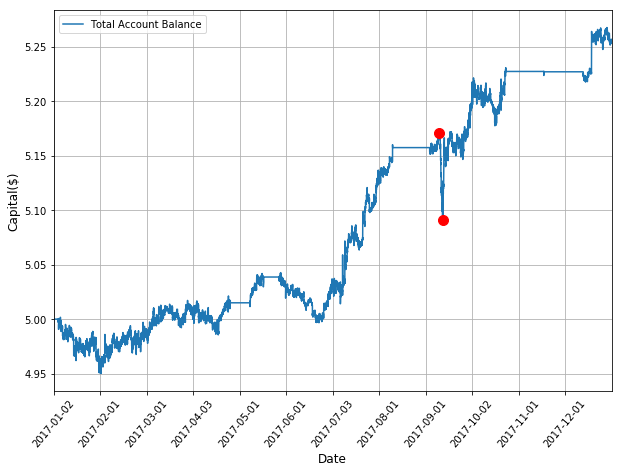

In [12]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [13]:
print('Corrected Annualized SR: {:.2f}'.format(0.11091235709690252*(252**0.5)))

Corrected Annualized SR: 1.76


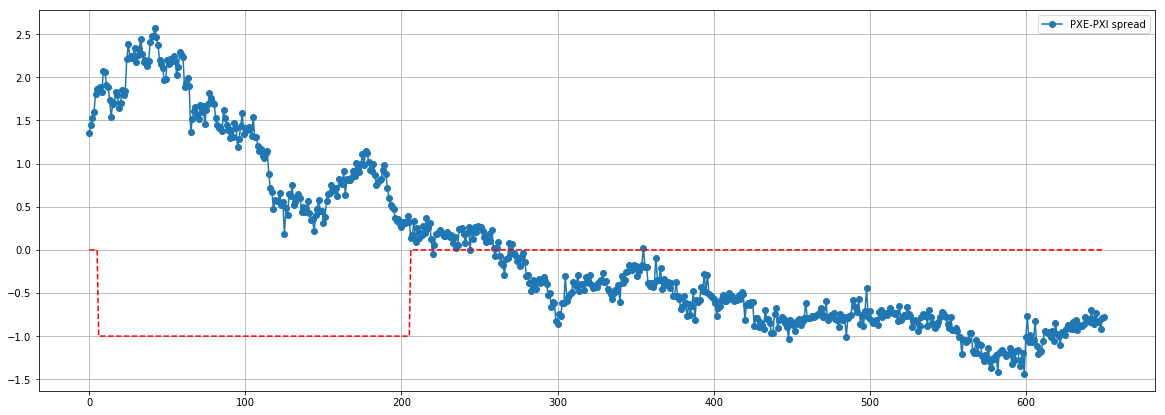

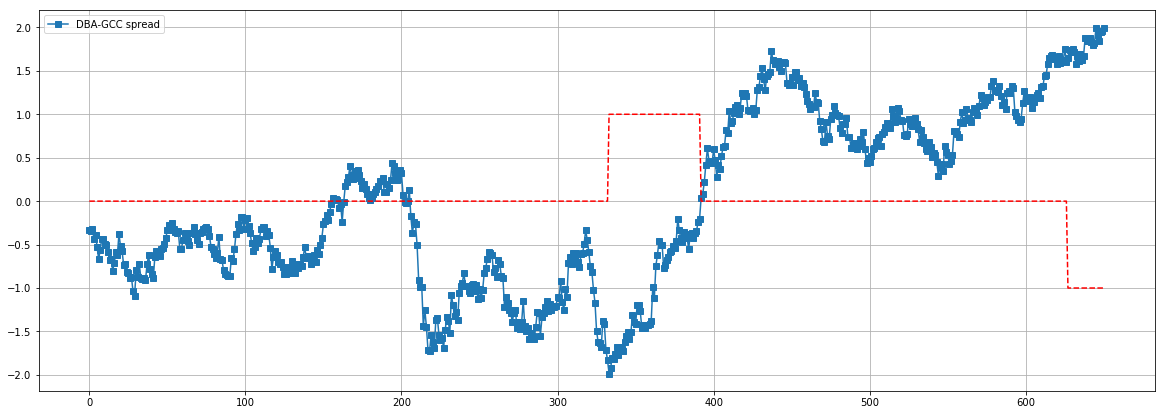

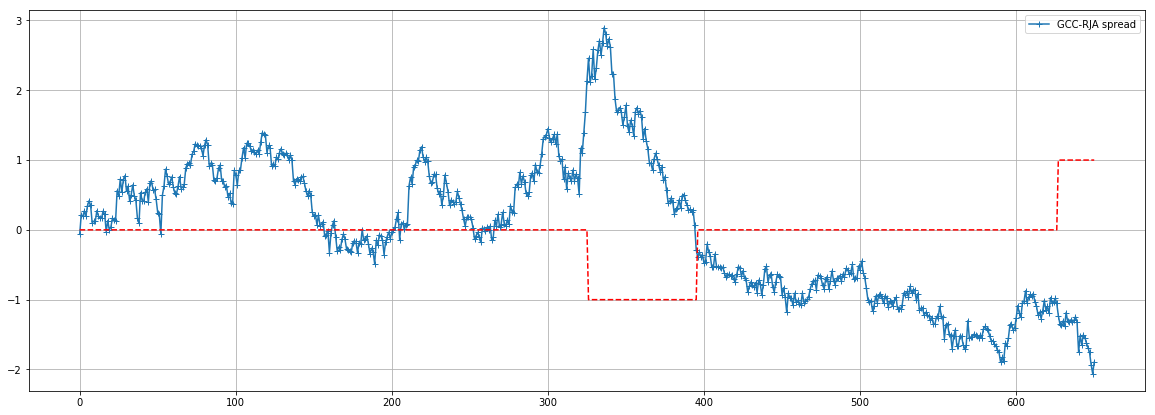

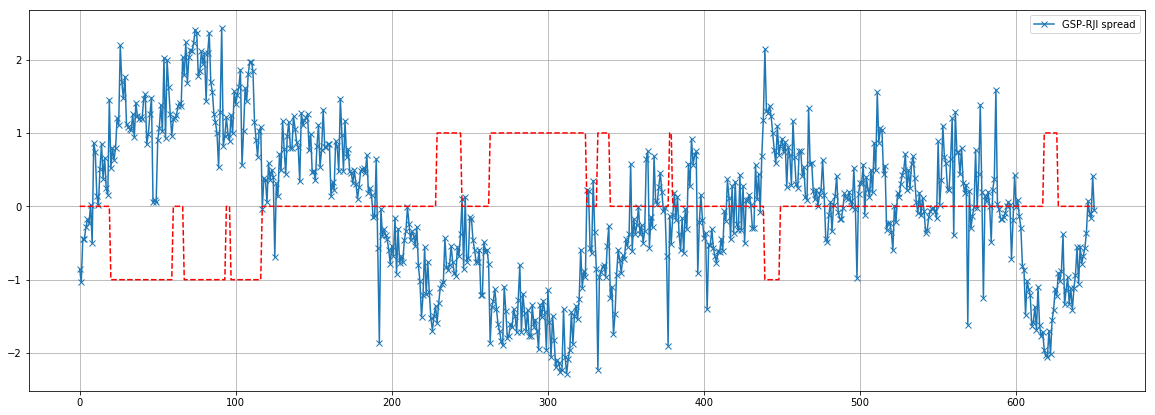

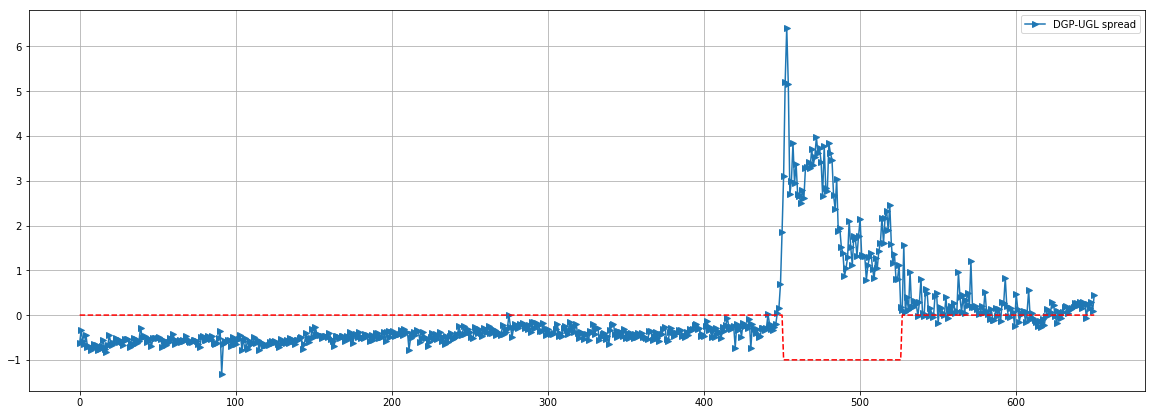

In [14]:
markers= ["o","s","+","x",">"]
for i in range(len(pairs)):
    plt.figure(figsize=(20,7))
    plt.grid()
    #performance_threshold_train[i][1]['norm_spread']
    plt.plot(performance_threshold_train[i][1]['norm_spread'].values[::30], marker=markers[i],
             label=performance_threshold_train[i][0][0]+'-'+performance_threshold_train[i][0][1]+' spread')
    plt.plot(performance_threshold_train[i][1]['position_during_day'].values[::30], linestyle='--', c='r')
    plt.legend()

In [15]:
cum_returns_threshold_train_w_costs

[-2.717286637287797,
 5.910124979411635,
 5.052327035364579,
 11.560630843916853,
 5.693539382506185]

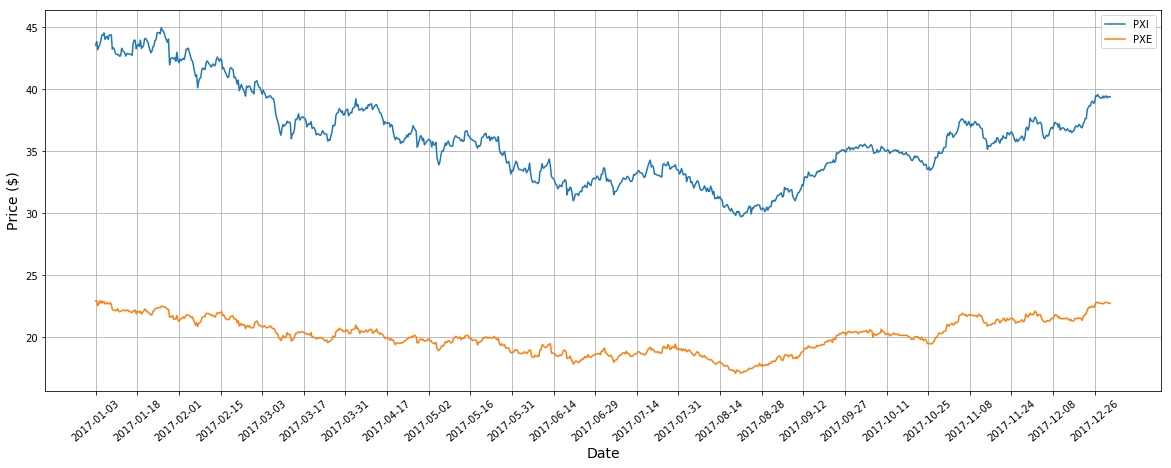

In [16]:
frequency_sampling = 20
i = 0
plt.figure(figsize=(20,7))
plt.grid()
#
plt.plot(performance_threshold_train[i][1]['PXI'].values[::frequency_sampling],
         label='PXI')
plt.plot(performance_threshold_train[i][1]['PXE'].values[::frequency_sampling],
         label='PXE')
# xticks
dates = performance_threshold_train[i][1]['PXI'][::frequency_sampling].index.date[::40]
xi = np.arange(0, len(performance_threshold_train[i][1]['PXI'][::frequency_sampling]), 40)
plt.xticks(xi, dates, rotation=40)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
#plt.ylim((-3,3))
#plt.plot(performance_threshold_train[i][1]['position_during_day'].values[::frequency_sampling],
#     linestyle='--', c='r', label='Position')
plt.legend()

In [17]:
performance_threshold_train[0][1]

,pnl,pnl_y,pnl_x,account_balance,returns,position_return,PXI,PXE,norm_spread,position_during_day,trading_duration,position_ret_with_costs
2017-01-03 14:35:00,0.0,0.0,0.0,1.000000,0.0,0.0,43.560,22.915,1.351883,0.0,0,0.0
2017-01-03 14:40:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.082,22.915,1.643083,0.0,0,0.0
2017-01-03 14:45:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.224,22.915,1.722298,0.0,0,0.0
2017-01-03 14:50:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.224,22.915,1.722298,0.0,0,0.0
2017-01-03 14:55:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.327,22.915,1.779757,0.0,0,0.0
2017-01-03 15:00:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.347,22.915,1.790914,0.0,0,0.0
2017-01-03 15:05:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.271,22.998,1.665974,0.0,0,0.0
2017-01-03 15:10:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.556,22.998,1.824962,0.0,0,0.0
2017-01-03 15:15:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.537,23.109,1.703973,0.0,0,0.0
2017-01-03 15:20:00,0.0,0.0,0.0,1.000000,0.0,0.0,44.537,23.109,1.703973,0.0,0,0.0


# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [18]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Keeping every pair

**Basic Threshold Strategy**

In [19]:
results_without_costs, results_with_costs, performance_threshold_test = trader.apply_trading_strategy(pairs,
                                                                                             'fixed_beta',
                                                                                             2,
                                                                                             0,
                                                                                             test_mode=True)
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 5/5

Annual ROI:  8.18792038485796
80.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.5687219735462907
Autocorrelation:  -0.06476794613661258
Daily Sharpe Ratio 0.15567935056143792
Total number of trades:  150
Positive trades:  90
Negative trades:  60
Total Drawdown Days: 83 days
Max DD period: 41.0 days
Maximum drawdown of portfolio: -1.56%


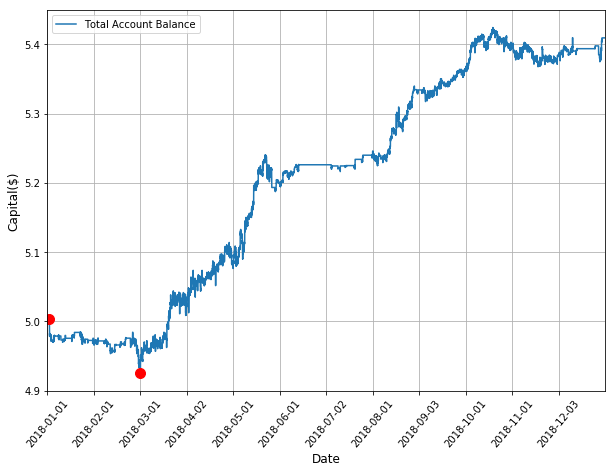

In [20]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [21]:
print('Corrected Annualized SR: {:.2f}'.format(0.15567935056143792*17.47))

Corrected Annualized SR: 2.72


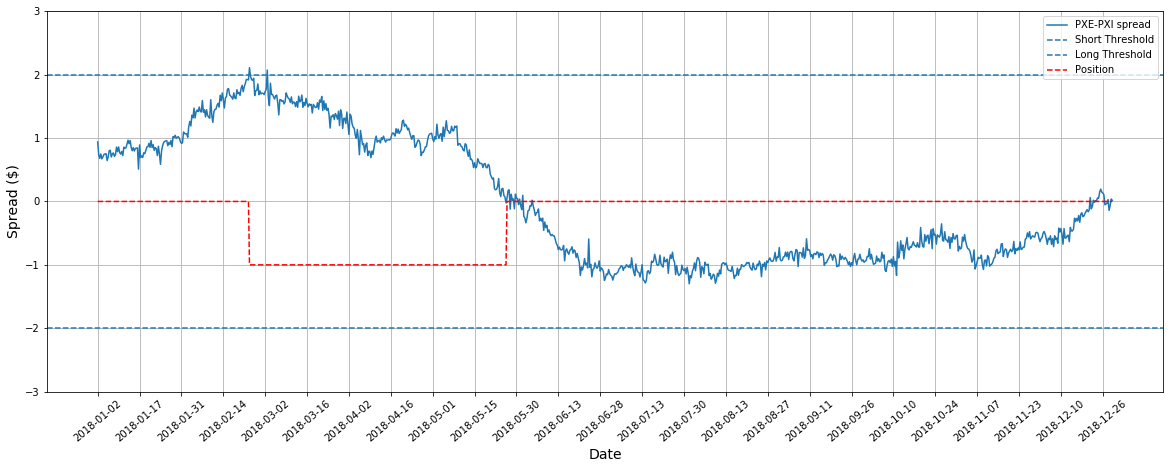

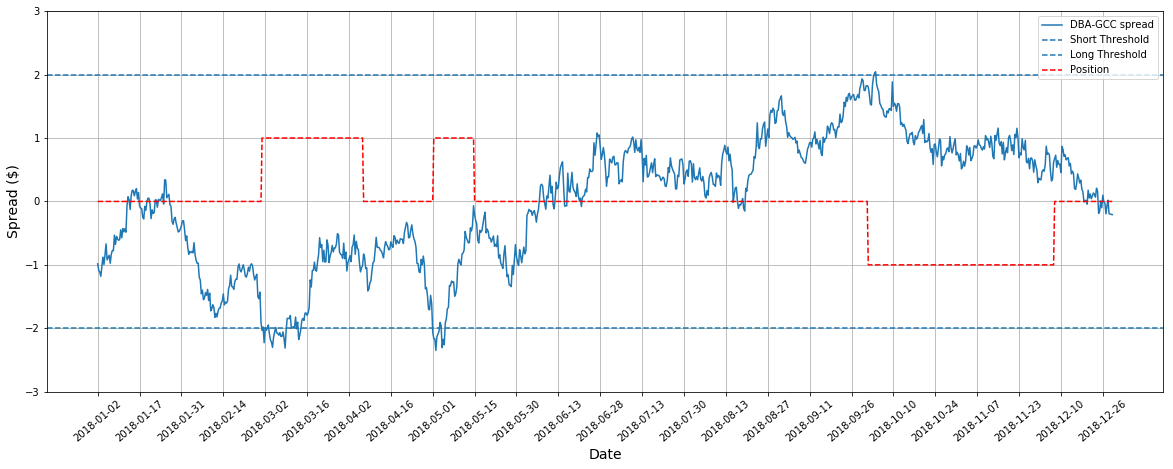

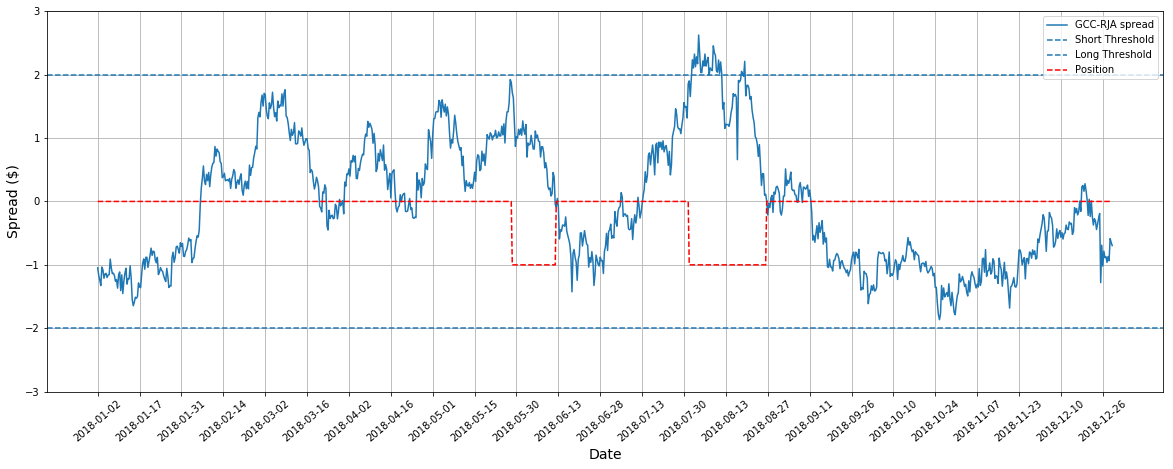

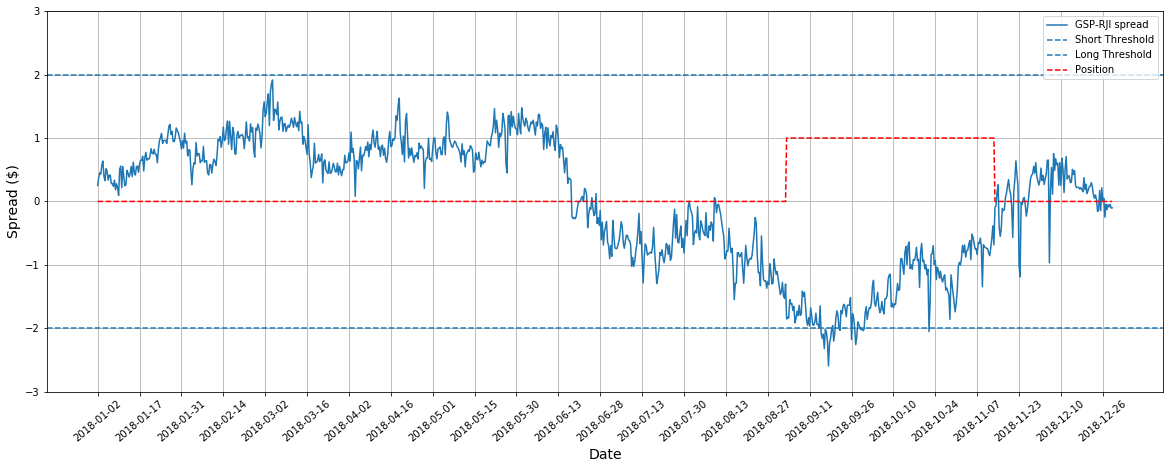

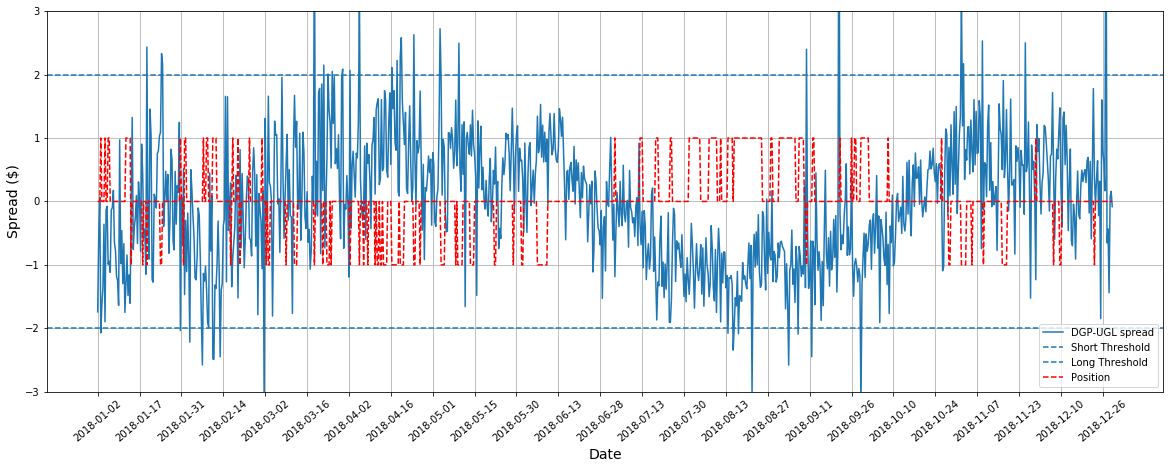

In [22]:
markers= ["o","x","+","s",">"]
frequency_sampling = 20
for i in range(len(pairs)):
    plt.figure(figsize=(20,7))
    plt.grid()
    #performance_threshold_train[i][1]['norm_spread']
    plt.plot(performance_threshold_test[i][1]['norm_spread'].values[::frequency_sampling],# marker=markers[i],
             label=performance_threshold_test[i][0][0]+'-'+performance_threshold_test[i][0][1]+' spread')
    # xticks
    dates = performance_threshold_test[i][1]['norm_spread'][::frequency_sampling].index.date[::40]
    xi = np.arange(0, len(performance_threshold_test[i][1]['norm_spread'][::frequency_sampling]), 40)
    plt.xticks(xi, dates, rotation=40)
    plt.axhline(y=2, linestyle='--', label='Short Threshold')
    plt.axhline(y=-2, linestyle='--', label='Long Threshold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Spread ($)', fontsize=14)
    plt.ylim((-3,3))
    plt.plot(performance_threshold_test[i][1]['position_during_day'].values[::frequency_sampling],
         linestyle='--', c='r', label='Position')
    plt.legend()

### Approach 2: Keeping only pairs that had positive returns in the training period

In [23]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [24]:
results_without_costs, results_with_costs, performance_threshold_test = trader.apply_trading_strategy(
                                                                                    profitable_pairs, 
                                                                                    'fixed_beta',
                                                                                    2,#entry_multiplier,
                                                                                    0,#exit_multiplier,
                                                                                    test_mode=True)
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 4/4

Annual ROI:  6.266750093702189
75.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  1.726393841613971
Autocorrelation:  -0.05775103483852495
Daily Sharpe Ratio 0.10588592084043545
Total number of trades:  149
Positive trades:  89
Negative trades:  60
Total Drawdown Days: 87 days
Max DD period: 40.0 days
Maximum drawdown of portfolio: -1.43%


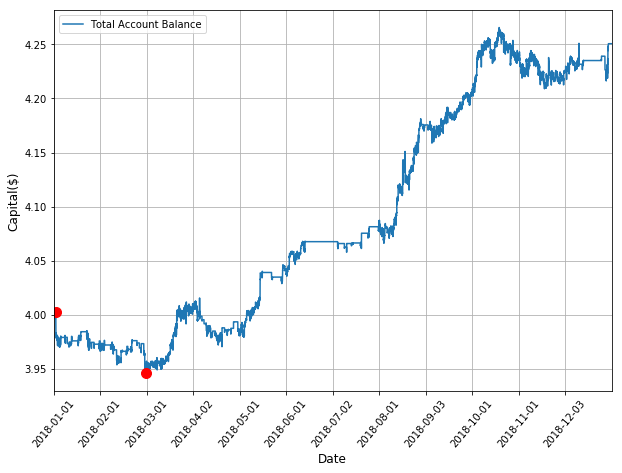

In [25]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [26]:
print('Corrected Annualized SR: {:.2f}'.format(0.10588592084043545*17.47))

Corrected Annualized SR: 1.85


Checking beta values and returns

In [27]:
betas = list()
for i in list(profitable_pairs_indices.flatten()):
    betas.append(pairs[i][2]['coint_coef'])
betas

[1.1848010535853197,
 0.28165908805607154,
 0.18642112727898758,
 0.6024381086001016]

# Validate the results

In [28]:
results

{'avg_annual_roi': 6.266750093702189,
 'avg_half_life': 920.0,
 'avg_hurst_exponent': 0.287624274752506,
 'avg_total_roi': 6.2667500937021945,
 'n_pairs': 4,
 'pct_pairs_with_positive_results': 75.0,
 'pct_positive_trades_per_pair': 64.6853146853147,
 'portfolio_sharpe_ratio': 0.10588592084043545}

Pair: DBA-GCC


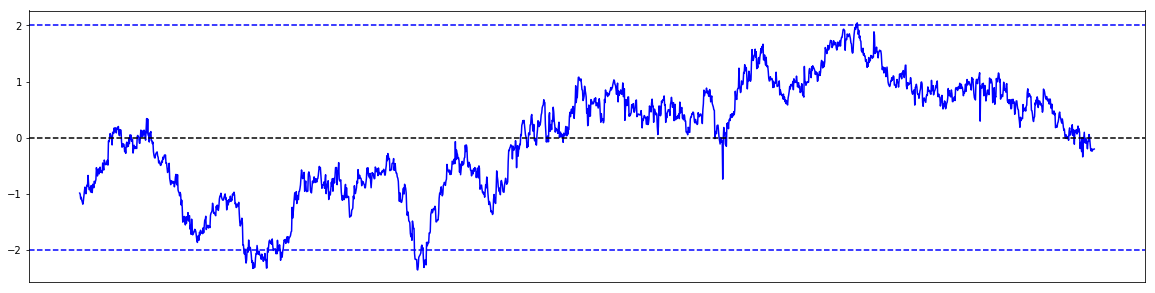

Pair: GCC-RJA


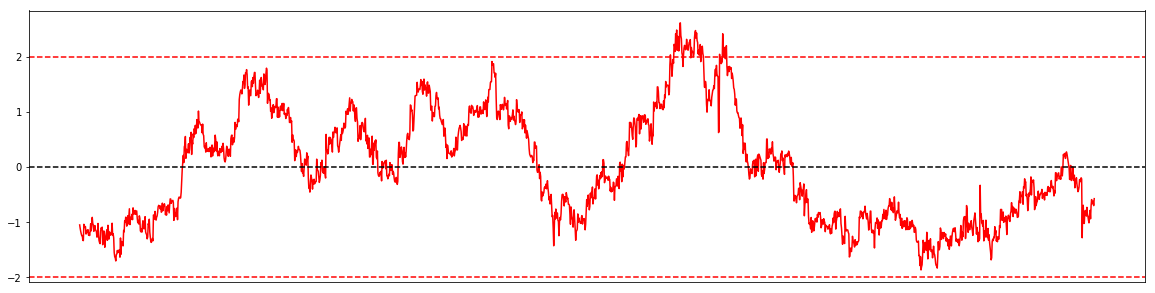

Pair: GSP-RJI


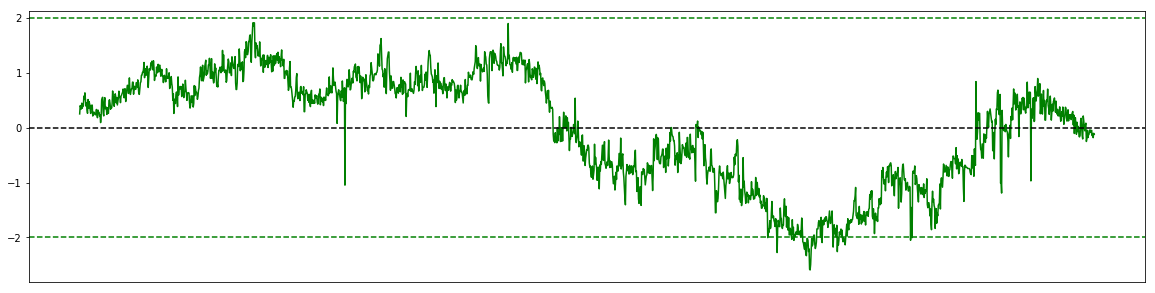

Pair: DGP-UGL


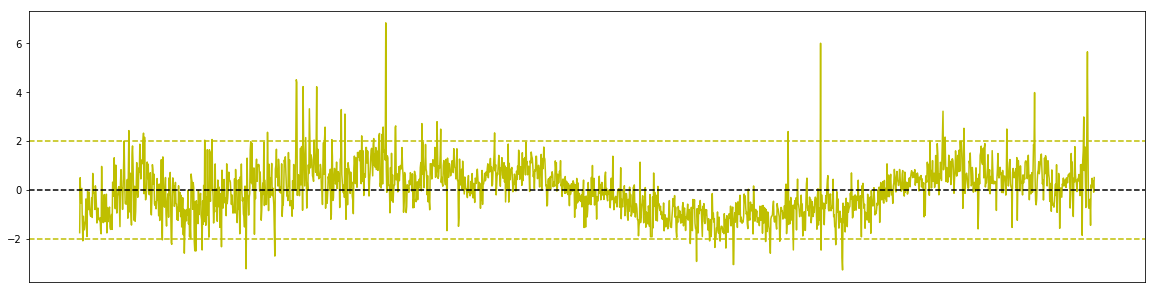

In [30]:
colors = ['b', 'r', 'g', 'y', 'pink']
for i in range(len(profitable_pairs)):
    print('Pair: {}-{}'.format(performance_threshold_test[i][0][0],performance_threshold_test[i][0][1]))
    
    plt.figure(figsize=(20,5))
    plt.plot(performance_threshold_test[i][1]['norm_spread'].values[::10], c=colors[i])
    
    std = performance_threshold_test[i][0][2]['spread'].std()
    mean = performance_threshold_test[i][0][2]['spread'].mean()
    plt.axhline(y=2, color=colors[i], linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=-2, color=colors[i], linestyle='--')
    plt.xticks([])
    plt.show()

# Result to show problem with standard model

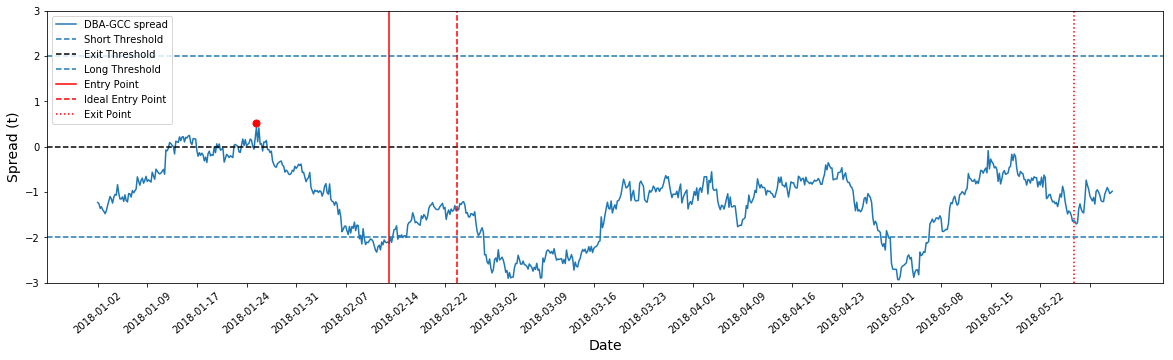

In [32]:
i=0
frequency_sampling = 10
plt.figure(figsize=(20,5))
plt.plot(performance_threshold_test[i][1]['norm_spread'].values[:105*78:frequency_sampling]*1.25,
         label=performance_threshold_test[i][0][0]+'-'+performance_threshold_test[i][0][1]+' spread')

std = performance_threshold_test[i][0][2]['spread'].std()
mean = performance_threshold_test[i][0][2]['spread'].mean()
plt.axhline(y=2, linestyle='--', label='Short Threshold')
plt.axhline(y=0, color='black', linestyle='--', label='Exit Threshold')
plt.axhline(y=-2, linestyle='--', label='Long Threshold')
plt.ylim((-3,3))
dates = performance_threshold_test[i][1]['norm_spread'][:100*78:frequency_sampling].index.date[::40]
xi = np.arange(0, len(performance_threshold_test[i][1]['norm_spread'][:105*78:frequency_sampling]), 40)
plt.xticks(xi, dates, rotation=40)
plt.plot([np.argmax(performance_threshold_test[i][1]['norm_spread'].values[:105*78:frequency_sampling])],
         [np.max(performance_threshold_test[i][1]['norm_spread'].values[:105*78:frequency_sampling])*1.25+0.1],
         'o', color='Red', markersize=7)
plt.axvline(x=235, color='red', label='Entry Point')
plt.axvline(x=290, color='red', linestyle='--', label='Ideal Entry Point')
plt.axvline(x=787, color='red', linestyle=':', label='Exit Point')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Spread (t)', fontsize=14)
plt.legend()
plt.show()

# Result to show definition of thresholds

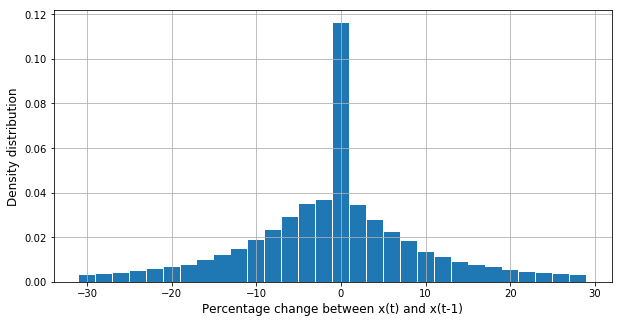

In [33]:
i = 4
spread_train = pairs[i][2]['spread'][:train_val_split]
spread_train_pct_change = (((spread_train - spread_train.shift(1))/abs(spread_train.shift(1))) * 100).dropna()
positive_changes = spread_train_pct_change[spread_train_pct_change > 0]
negative_changes = spread_train_pct_change[spread_train_pct_change < 0]

plt.figure(figsize=(10,5))
plt.grid()
plt.hist(x=np.asarray(spread_train_pct_change.values), normed=True, bins=30, range=(-30,30),align='left',
         rwidth=0.95)
plt.xlabel('Percentage change between x(t) and x(t-1)', size=12)
plt.ylabel('Density distribution', size=12)
#plt.legend()
plt.show()

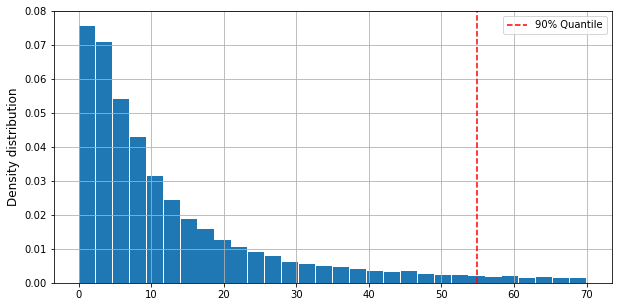

In [34]:
plt.figure(figsize=(10,5))
plt.grid()
plt.hist(x=np.asarray(positive_changes.values), normed=True, bins=30, range=(0,70),align='mid',
         rwidth=0.95)
long_threshold = positive_changes.quantile(q=0.9, interpolation='linear')
plt.axvline(x=long_threshold, color='red', linestyle='--', label='90% Quantile')
#plt.xlabel('Positive percentage change values between x(t) and x(t-1)', size=12)
plt.ylabel('Density distribution', size=12)
plt.ylim((0,0.08))
plt.legend()
plt.savefig('positive_changes.png')
plt.show()

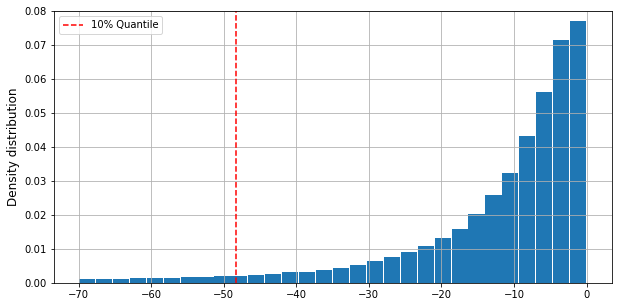

In [35]:
plt.figure(figsize=(10,5))
plt.grid()
plt.hist(x=np.asarray(negative_changes.values), normed=True, bins=30, range=(-70,0),align='mid',
         rwidth=0.95)
short_threshold = negative_changes.quantile(q=0.1, interpolation='linear')
plt.axvline(x=short_threshold, color='red', linestyle='--', label='10% Quantile')
#plt.xlabel('Negative percentage change values between x(t) and x(t-1)', size=12)
plt.ylabel('Density distribution', size=12)
plt.ylim((0,0.08))
plt.legend()
plt.savefig('negative_changes.png')
plt.show()

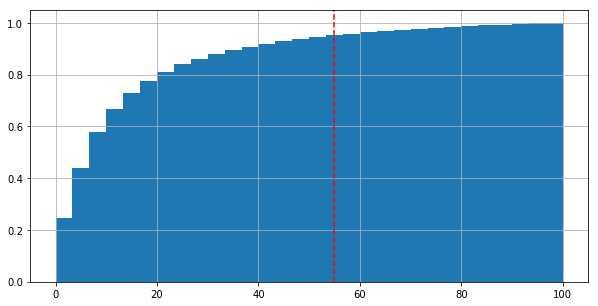

In [36]:
plt.figure(figsize=(10,5))
plt.grid()
long_threshold = positive_changes.quantile(q=0.9, interpolation='linear')
plt.hist(x=np.asarray(positive_changes.values), normed=True, bins=30, range=(0,100), cumulative=True, align='mid')
plt.axvline(x=long_threshold, color='red', linestyle='--', label='90% Quantile')
plt.show()